In [1]:
!git clone https://github.com/niazwazir/VTRG_Corona_Virus_Detection.git

Cloning into 'VTRG_Corona_Virus_Detection'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 220 (delta 31), reused 174 (delta 14), pack-reused 0
Receiving objects: 100% (220/220), 48.69 MiB | 21.35 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
cd VTRG_Corona_Virus_Detection/

/content/VTRG_Corona_Virus_Detection


In [3]:
#importing the necessary packages
import numpy as np
import cv2
import os
from imutils import paths
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, Xception, ResNet50, VGG19, DenseNet121, DenseNet169, DenseNet201, ResNet101, ResNet101V2, ResNet152, ResNet152V2, ResNet50V2, InceptionResNetV2, InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [4]:
#setting arguments 
args = {"dataset": "./dataset",
        "model": "corona.model"
       }

In [5]:
"""initializing the initial learning rate, epochs to train
   and batch size"""
learningRate = 1e-3
epochs = 500
batchSize = 8

In [6]:
"""listing out the images in the dataset folder, then initializing
   the list of data (images) and class images"""
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

#looping over the images paths
for imagePath in imagePaths:
    
    #extracting the class label from image paths
    label = imagePath.split(os.path.sep)[-2]

    """loading the images, changing color channels and resizing it to be a fixed
       224x224 pixels"""
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    #updating the data and labels lists
    data.append(image)
    labels.append(label)

"""converting the data and labels to NumPy arrays and scaling the pixel
   intensities to the range [0, 255]"""
data = np.array(data) / 255.0
labels = np.array(labels)

In [7]:
#using one-hot encoding on labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

"""splitting the data into training and testing using 80% of
   the data for training and 20% for testing"""
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, 
                                                  random_state=42)

#initializing the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [8]:
#loading the VGG16 network, ensuring the head FC layer sets are left
#baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = DenseNet169(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = DenseNet201(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =  ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =  ResNet101V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =  ResNet152(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =  ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel =  ResNet50V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
baseModel =  InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
"""constructing the main model that will be placed on top of the
   the base model"""
mainModel = baseModel.output

mainModel = AveragePooling2D(pool_size=(4, 4))(mainModel)
mainModel = Flatten(name="flatten")(mainModel)
mainModel = Dense(64, activation="relu")(mainModel)
mainModel = Dropout(0.5)(mainModel)
mainModel = Dense(2, activation="softmax")(mainModel)

#lace the head FC model on top of the base model (actual model)
model = Model(inputs=baseModel.input, outputs=mainModel)

"""looping over all layers in the base model and freeze them so they will 
   not be updated during the first training process"""
for layer in baseModel.layers:
    layer.trainable = False

219062272/219055592 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
import keras
import tensorflow as tf

In [11]:
tf.keras.utils.plot_model(model, 'Wazir_first_model.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.585868 to fit



In [12]:
#compiling up the model
optimizer = Adam(lr=learningRate, decay=learningRate / epochs)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

#training the head of the network
networkHead = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=batchSize),
    steps_per_epoch=len(trainX) // batchSize,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batchSize,
    epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
11/11 [==============================] - 5s 412ms/step - loss: 0.9544 - accuracy: 0.6463 - val_loss: 0.0993 - val_accuracy: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 96ms/step - loss: 0.7151 - accuracy: 0.7439 - val_loss: 0.0564 - val_accuracy: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 96ms/step - loss: 0.5630 - accuracy: 0.7439 - val_loss: 0.0489 - val_accuracy: 1.0000
Epoch 4/500
11/11 [==============================] - 1s 95ms/step - loss: 0.2603 - accuracy: 0.9024 - val_loss: 0.0429 - val_accuracy: 1.0000
Epoch 5/500
11/11 [==============================] - 1s 95ms/step - loss: 0.2636 - accuracy: 0.8780 - val_loss: 0.0251 - val_accuracy: 1.0000
Epoch 6/500
11/11 [==============================] - 1s 100ms/step - loss: 0.2370 - accuracy: 0.9091 - val_loss: 0.0308 - val_accuracy: 1.0000
Epoch 7/500
11/11 [==============================] - 1s 96ms/step - lo

In [13]:
#making predictions on the testing data
predIndexs = model.predict(testX, batch_size=batchSize)

"""for each image in the testing data we need to find the index of the
   label with corresponding largest predicted probability"""
predIndexs = np.argmax(predIndexs, axis=1)

#printing classification report
print(classification_report(testY.argmax(axis=1), predIndexs, target_names=lb.classes_))

              precision    recall  f1-score   support

    infected       1.00      1.00      1.00        13
  uninfected       1.00      1.00      1.00        10

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



In [14]:
#computing the confusion matrix and use it to derive the raw accuracy
cm = confusion_matrix(testY.argmax(axis=1), predIndexs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total

# printing confusion matrix, accuracy
print(cm)
print("acc: {:.4f}".format(acc))

[[13  0]
 [ 0 10]]
acc: 1.0000


In [15]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
class_names = ["Covid-19","Normal"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="plasma"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "blue")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
from matplotlib.font_manager import FontProperties

def plot_cm(labels, predictions):
    '''
    Plot the confusion matrix
    '''

    font = FontProperties()
    font.set_family('serif')
    font.set_name('Times New Roman')
    # font.set_style('italic')

    print(classification_report(labels, predictions, target_names=['Normal', 'Covid-19'], digits=3))

    cm = confusion_matrix(labels, predictions)
    print()

    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 20})
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title('Confusion Matrix',fontsize=30, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label: Normal (0), Covid-19 (1)', fontsize=20)

In [17]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


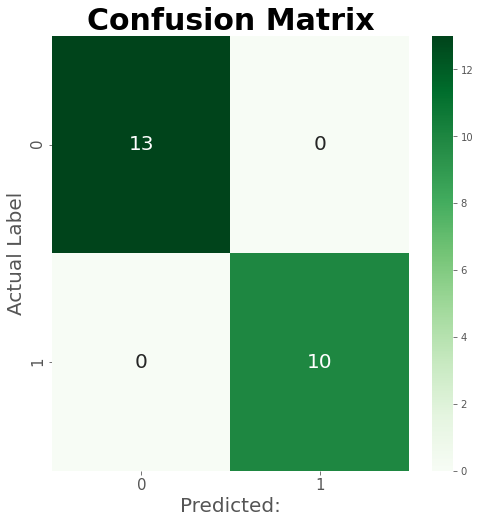

In [39]:
#plt.figure()
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="g",cmap='Greens',annot_kws={"size": 20})
#plot_confusion_matrix(cm, classes=class_names,
                      #title='Confusion matrix for Covid-19 Detection',cmap="plasma
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Confusion Matrix',fontsize=30, fontweight='bold')
#ax.set_xlabel('Predicted'); ax.set_ylabel('True Label')
plt.ylabel('Actual Label', fontsize=20)
plt.xlabel('Predicted: Normal (0), Covid-19 (1)', fontsize=20)
plt.savefig('confusion_matrix.pdf', format='pdf')

**List all data in history**

In [19]:
history = networkHead
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**Summarize history for accuracy**

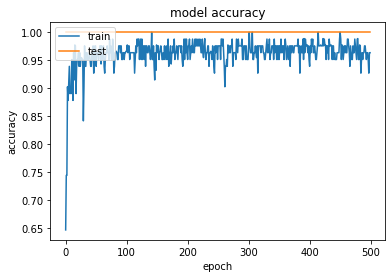

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Summarize history for loss**

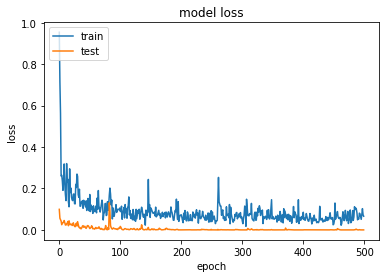

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

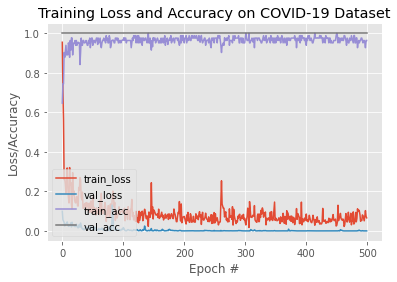

<Figure size 432x288 with 0 Axes>

In [22]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), networkHead.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), networkHead.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), networkHead.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), networkHead.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig("plot.png")

In [23]:
#saving the model
model.save(args["model"])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: corona.model/assets


In [24]:
!ls

confusion_matrix.pdf	    plot.png			train_model.ipynb
corona.model		    README.md			VGG16_COVID_19.ipynb
dataset			    ResNet101_COVID_19.ipynb	VGG19_COVID_19.ipynb
DenseNet121_COVID_19.ipynb  ResNet101V2_COVID_19.ipynb	Wazir_first_model.png
DenseNet169_COVID_19.ipynb  ResNet152_COVID_19.ipynb	Xception_COVID_19.ipynb
DenseNet201_COVID_19.ipynb  ResNet152V2_COVID_19.ipynb
output			    ResNet50V2_COVID_19.ipynb


In [25]:
#testing out the model
import tensorflow as tf

#loading the model
model = tf.keras.models.load_model("corona.model")

In [26]:
testImage = cv2.imread("./dataset/infected/A.jpeg") #For Positive Case
#testImage = cv2.imread("./dataset/infected/B.jpeg") #For Negative Case

In [27]:
#preprocessing the test image
image = cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
image = image.astype("float") / 255.0

In [28]:
#reshaping the numpy array according to image size
image = np.array(image).reshape(1,224,224,3)

#doing prediction on test image
pred = model.predict(image)
pred = pred.argmax(axis=1)[0]

In [29]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

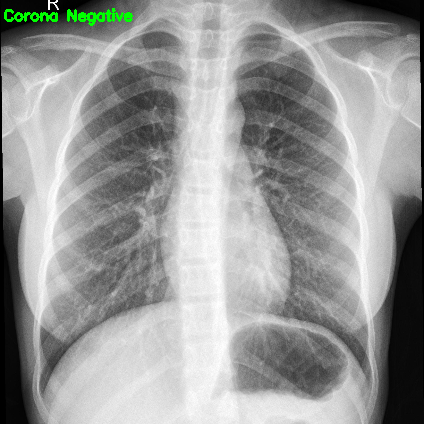

In [30]:
#putting text on image and showing output image
imageText = "Corona Negative" if pred == 1 else "Corona Positive"
color = (0, 255, 0) if pred == 1 else (0, 0, 255)

testImage = cv2.resize(testImage, (424, 424))
cv2.putText(testImage, imageText, (3, 20), cv2.FONT_ITALIC, 0.5,color, 2)
cv2_imshow(testImage)